In [1]:
import random as rn
import numpy as np
import numpy.ma as MA
import math as mt
import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl
import sys 
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from pylab import *
import scipy.io.idl  


In [4]:
# CONSTANTS

M_sun = 1.98841586057e+33     # solar mass [gr]
R_sun = 6.955e+10             # solar radius [cm]
#M     = 1.                    # stellar mass in solar masses 
#R     = 1.                    # stellar radius in solar radii
IKM   = 9.e21                 # I (moment of inertia) over Km (aml efficiency constant) 
G = 6.67*1.e-8                 # Newton's constant in cm^3 g^-1 s^-2


# PARAMETERS

# time, steps, and sample size parameters

N = 10            # sample size (number of stars)
Age = 100000.                    # oldest cluster's age [million years]
tf = Age *(10**6*365.)   # final time (cluster's age)  [d]
ti = 5.*(10**6*365.)      # initial [d] 
steps = 500#1000    
minP = 0.
maxP = 25.
minBV = 0.45
maxBV = 1.7
bn = 100 # number of bins for histogram



In [10]:
# INITIAL CONDITIONS

P0 = np.array([ 0.2,  0.25, 0.3,  0.35,  0.4, 0.5, 0.6, 1., 2, 5., 10.])       # defining array of initial periods in days
N = P0.shape[0]
M =0.9 # Initial Stellar Mass in M_{sun}  

In [6]:
# Load Data

MIST=np.loadtxt('MIST_data/00{:02d}0M.track.eep'.format(int(M*10)))
AGE_mist = MIST[:,0]
TAU_mist = MIST[:,80]/86400
MOI_mist = MIST[:,89]
#TAU_mist[TAU_mist<0.01] = 0.01

tt=min(range(AGE_mist[:].shape[0]), key= lambda ii:abs(AGE_mist[ii]-4.5*10**9))

In [7]:
# EVOLVE ALGORITHM


P=np.tile(P0, (AGE_mist.shape[0],1))
P=np.transpose(P)

l = np.array(np.ones(N)*10.)  # Highest complexity for all stars
L = np.ones((N, AGE_mist.shape[0]))  #angular momentum array
t_prev = ti 
max_age = 10**10

In [8]:
# Disk Locking

Pt0 = (0.*np.random.random(N) + 13.)  #*24.*60.*60.)    # period at which each star will start its evolution [Myrs]
Pt0[Pt0 < 0] = 0


ind0 = np.ones(N, dtype=int)
for j in range(N):
    ind0[j]= min(range(AGE_mist.shape[0]), key= lambda ii:abs(AGE_mist[ii]-Pt0[j]*10**6))
    L[j, ind0[j]]=MOI_mist[ind0[j]]*2*mt.pi/(P[j,0])    # Angular Momentum
  

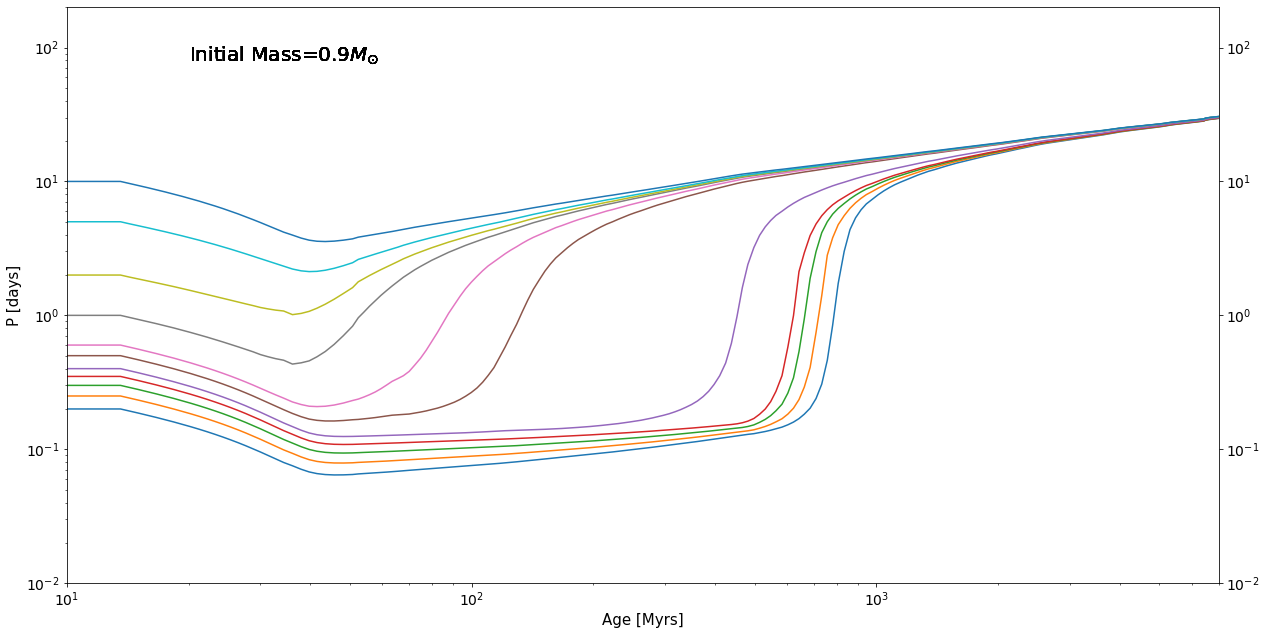

In [9]:
fig = plt.figure(figsize=(20, 10))
fig.add_axes([ 0.1, 0.1, 0.8, 0.8]) #real plot
for j in range(N):                                # N for each star
    Omega = 2*mt.pi/(P[j, 0])  # initial angular velocity for the interval  
    for i in range(ind0[j]+1,  (AGE_mist[AGE_mist<max_age]).shape[0]-1): # steps in MIST table
        dt= (AGE_mist[i+1]-AGE_mist[i])*365
        Jdip = 2.*10**41*Omega**3*TAU_mist[i] # Value from MHD silmulations callibrated to the Sun. 1x10^41, much less peels off low mass early
        Ro=P[j,i]/TAU_mist[i] # Rossby number
        l[j] =0.02/Ro+2*Ro+1.# complexity function, n in Garraffo et al 2018 
        l[np.where(l<1.)]=1.
        l[np.where(l>8)]= 8 #l[np.where(l>8.)]*0.6
        #l[:]=1.  # Turn this on to ignore complexity: Skumanich evolution
        Kmorph =4.05*mt.exp(-1.4*l[j])  # Magnetic complexity modulation of AML. Q(n) in Garraffo et al 2018
        Jdot =  Kmorph*Jdip  # Modulate angular momentum loss
        Omega = L[j,min(abs(i), abs(i-1))]/MOI_mist[i]
        P[j,min(i+1,AGE_mist.shape[0]-1)] = 2*mt.pi/Omega
        Omega = Omega - dt*Jdot/MOI_mist[i]
        L[j,i] = MOI_mist[i]* Omega
    plt.xlim([10,0.7*10**4])
    plt.ylim([ 0.01, 200])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Age [Myrs]', fontsize=15)
    plt.ylabel('P [days]', fontsize=15)
    plt.plot( AGE_mist/10**6, P[j,:])
    plt.tick_params(labelsize=14)
    plt.tick_params(labelsize=14)
    plt.tick_params(labelsize=14)
    plt.tick_params(axis='y', which='both')
    plt.tick_params(bottom=True, left=True, right=True)
    plt.tick_params(which='both',labelright=True)
    plt.text(20, 80, r'Initial Mass={}'.format(M)+'$M_{\odot}$',  fontsize=20)
    np.savetxt('age_p_tau_Mass{:02d}_P0={:2d}.txt'.format(int(M*10),int(P0[j]*10)), np.column_stack([AGE_mist/10**6, P[j,:], TAU_mist]))
    np.savetxt('AGE_Myrs', (AGE_mist/10**6, P[j,:], TAU_mist), fmt='%f')
fig.savefig('single_mass.ps')
plt.show()
